In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from heagan.tools.functions import pymatgen_comp, data_generator, check_cuda
from heagan.tools.generative_models import Generator, Discriminator
from joblib import dump
from heagan.tools.cGAN_samplers import noise_sampler, prop_sampler
from heagan.tools.plotting import plot
import json
from importlib import resources
import onnxruntime

In [2]:
with resources.files('heagan.dataset').joinpath('demo_dataset_true.csv') as fname:
    demo_df = pd.read_csv(fname,index_col = 0)

comps = pymatgen_comp(demo_df['Composition'].values)
dset = data_generator(comps, use_all_eles=False)
props = demo_df.iloc[:,1:].values.astype('float32')
prop_names = list(demo_df.columns[1:])
scaling_pipe = Pipeline([('Scaler',QuantileTransformer(output_distribution='normal')),('KDE',KernelDensity(kernel='gaussian',bandwidth=0.5))])
scaling_pipe.fit(props)
scaled_props = scaling_pipe['Scaler'].transform(props)

with resources.files('heagan.saved_cGAN').joinpath('scale_kde_pipe.joblib') as fname:
    dump(scaling_pipe,fname)

In [3]:
batch_size = 512
minibatch_size = batch_size
prop_dim = scaled_props.shape[1]
latent_dim = 4
gen_in = latent_dim + prop_dim
hidden = gen_in*2
n_hidden = 3
gen_out = dset.size
generator = Generator(gen_in,n_hidden,hidden,gen_out)
discriminator = Discriminator(gen_out+prop_dim,n_hidden,hidden,1)
optim_betas = (0.5, 0.999)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001,betas=optim_betas)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001,betas=optim_betas)
cuda = check_cuda()
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
loss = nn.BCELoss()
d_steps = 1
g_steps = 1
prefix = 'Epoch'
num_iterations = int(2e4)
log_interval = int(5e2)

In [4]:
def d_loop():
  discriminator_optimizer.zero_grad()
  train_data, train_idx = dset.sample(batch_size)
  train_prop = scaled_props[train_idx]
  d_real_data = torch.from_numpy(train_data)
  d_real_prop = torch.from_numpy(train_prop)
  if cuda:
        d_real_data = d_real_data.cuda()
        d_real_prop = d_real_prop.cuda()
  
  true_discriminator_out = discriminator(d_real_data,d_real_prop)
  true_labels = torch.ones_like(true_discriminator_out)
  true_discriminator_loss = loss(true_discriminator_out, true_labels)


  d_gen_input = torch.from_numpy(noise_sampler(batch_size, latent_dim))

  if cuda:
        d_gen_input = d_gen_input.cuda()
  with torch.no_grad():
        generated_data = generator(d_gen_input,d_real_prop)
  
  generator_discriminator_out = discriminator(generated_data.detach(),d_real_prop)
  generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros_like(generator_discriminator_out))
  discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
  discriminator_loss.backward()
  discriminator_optimizer.step()

In [5]:
def g_loop():
  generator_optimizer.zero_grad()
  
  d_gen_input = torch.from_numpy(noise_sampler(batch_size, latent_dim))
  d_gen_prop = prop_sampler(batch_size,prop_dim,'kde')
  d_gen_prop =  torch.from_numpy(d_gen_prop)#sample between lowest and highest LC values, uniform 
  if cuda:
        d_gen_input = d_gen_input.cuda()
        d_gen_prop = d_gen_prop.cuda()
  generated_data = generator(d_gen_input,d_gen_prop)
  generator_discriminator_out = discriminator(generated_data,d_gen_prop)
  true_labels = torch.ones_like(generator_discriminator_out)
  generator_loss = loss(generator_discriminator_out, true_labels)
  generator_loss.backward()
  generator_optimizer.step()

In [6]:
def g_sample():
    with torch.no_grad():
        gen_input = torch.from_numpy(noise_sampler(minibatch_size, latent_dim))
        #prop_input = np.random.uniform(max,min,(minibatch_size,prop_dim)).astype('float32')
        prop_input = prop_sampler(minibatch_size,prop_dim,'kde')
        prop_input =  torch.from_numpy(prop_input)
        if cuda:
            gen_input = gen_input.cuda()
            prop_input = prop_input.cuda()
        g_fake_data = generator(gen_input,prop_input)
        return g_fake_data.cpu().numpy()

In [7]:
samples = []
for it in range(num_iterations):
    d_infos = []
    for d_index in range(d_steps):
        d_loop()
    for g_index in range(g_steps):
        g_loop()
    
    if it == 0 or (it + 1) % log_interval == 0:
        g_fake_data = g_sample()
        samples.append(g_fake_data)
        #plot(g_fake_data, title='[{}] Iteration {}'.format(prefix, it+1),dset = dset)
        train_epoch = it+1

In [8]:
gan_hyperparameters = {
    'latent_dim' : latent_dim,
    'selected_props':prop_names,
    'prop_dim' : prop_dim,
    'elem_list':dset.elements.tolist()
}

with resources.files('heagan.saved_cGAN').joinpath('gan_hyperparameters.json').open('w') as f:
    json.dump(gan_hyperparameters,f)

model_scripted = torch.jit.script(generator.cpu())
with resources.files('heagan.saved_cGAN').joinpath('generator.pt') as fname:
    model_scripted.save(fname)

In [9]:
n = 500
noise = torch.from_numpy(noise_sampler(n, latent_dim))
props = torch.from_numpy(scaling_pipe['KDE'].sample(n).astype('float32'))
if cuda:
    noise = noise.cuda()
    props = props.cuda()
with torch.no_grad():
    generated = generator(noise,props)

In [10]:
from heagan.tools.functions import calculate_entropy_mixing, decode
from joblib import load
res = np.zeros((n,len(prop_names)))
for i,prop in enumerate(prop_names):
    decoded_comps = [decode(x,dset.elements) for x in generated.numpy()]
    if prop == 'delta_S':
        res[:,0] = [calculate_entropy_mixing(x) for x in decoded_comps]
    else:
        with resources.files('heagan.newSurrogates').joinpath(f'surrogate_{prop}.onnx') as fname:
            model = onnxruntime.InferenceSession(str(fname))
            pred = model.run([model.get_outputs()[0].name],
                                 {model.get_inputs()[0].name: generated.numpy()})[0]
            res[:,i] = pred.flatten()

delta_S 0.09615164423733998
d_param 0.02971606522770544
price 703.1015661434586
FT 0.6218087069754392
density 0.2706011636523708
hardness 2.10250650507546
uts1200C 0.03721927058059692


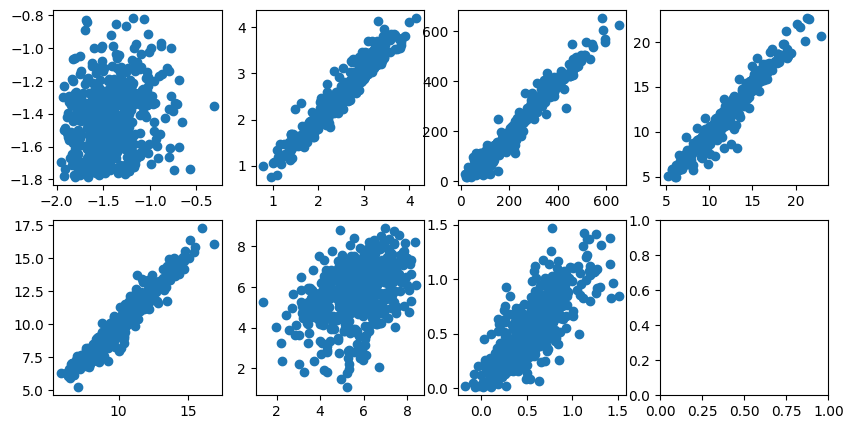

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
fig,ax = plt.subplots(2,4,figsize = (10,5))
ax = ax.ravel()
for i, p in enumerate(prop_names):
    ax[i].scatter(res[:,i], scaling_pipe['Scaler'].inverse_transform(props.to('cpu').detach().numpy())[:,i])
    print(p, mean_squared_error(res[:,i], scaling_pipe['Scaler'].inverse_transform(props.to('cpu').detach().numpy())[:,i]))